# Here I (Kyle) implement an RNN for binary classification

In [43]:
#Imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from IPython import display

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CLEANit/tutorials/blob/master/RNN-Classification-Tutorial.ipynb)

# Dataset:

NAME: Sonar, Mines vs. Rocks

SUMMARY: This is the data set used by Gorman and Sejnowski in their study
of the classification of sonar signals using a neural network [1].  The
task is to train a network to discriminate between sonar signals bounced
off a metal cylinder and those bounced off a roughly cylindrical rock.


For the angle independent experiments, Gorman and Sejnowski report the
following results for networks with different numbers of hidden units:

<br />Hidden&ensp;&ensp;% Right on&ensp;&ensp;Std.&ensp;&ensp;&ensp;&ensp;% Right on&ensp;&ensp;Std.<br />Units&ensp;&ensp;&ensp;Training set&ensp;&ensp;&ensp;&ensp;Dev.&ensp;&ensp;&ensp;&ensp;Test Set&ensp;&ensp;&ensp;&ensp;Dev.<br />------&ensp;&ensp;------------&ensp;&ensp;&ensp;&ensp;----&ensp;&ensp;&ensp;&ensp;----------&ensp;&ensp;----<br />0&ensp;&ensp;&ensp;89.4&ensp;&ensp;&ensp;&ensp;2.1&ensp;77.1&ensp;&ensp;&ensp;&ensp;8.3<br />2&ensp;&ensp;&ensp;96.5&ensp;&ensp;&ensp;&ensp;0.7&ensp;81.9&ensp;&ensp;&ensp;&ensp;6.2<br />3&ensp;&ensp;&ensp;98.8&ensp;&ensp;&ensp;&ensp;0.4&ensp;82.0&ensp;&ensp;&ensp;&ensp;7.3<br />6&ensp;&ensp;&ensp;99.7&ensp;&ensp;&ensp;&ensp;0.2&ensp;83.5&ensp;&ensp;&ensp;&ensp;5.6<br />12&ensp;&ensp;99.8&ensp;&ensp;&ensp;&ensp;0.1&ensp;84.7&ensp;&ensp;&ensp;&ensp;5.7<br />24&ensp;&ensp;99.8&ensp;&ensp;&ensp;&ensp;0.1&ensp;84.5&ensp;&ensp;&ensp;&ensp;5.7
















REFERENCES: 

1. Gorman, R. P., and Sejnowski, T. J. (1988).  "Analysis of Hidden Units
in a Layered Network Trained to Classify Sonar Targets" in Neural Networks,
Vol. 1, pp. 75-89.




(208, 60) (208, 1)


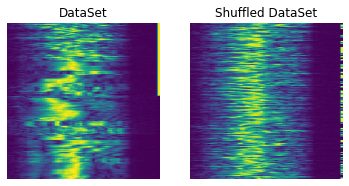

In [14]:
Data=[]
Labels=[]
#The data I have is legit just in a plain text file
with open('sonar.txt','r') as f:
    for ln in f:
        Data+=[[float(a) for a in ln[:-1].split(',')[:-1]]]
        #this ends up being 0 if it's a cylinder and 1 if it's a rock
        Labels+=[[int(ln[-2]=='R')]]
        
#casting to numpy array
Data=np.array(Data)
Labels=np.array(Labels)
#confirm the size of the arrays
print(Data.shape,Labels.shape)
#plotting the dataset before and after a shuffle
fig, (ax1,ax2)=plt.subplots(1,2) 
#here i'm adding the labels to the end so you can see which 
#signitura gives which label (yellow should be for a rock)
ax1.imshow(np.concatenate([Data,Labels],axis=1),aspect=0.3)
ax1.set_title("DataSet")
ax1.axis('off')
#208 is the number of samples (it's really small but what can you do)
perm=np.random.permutation(208)
Data=Data[perm]
Labels=Labels[perm]
ax2.imshow(np.concatenate([Data,Labels],axis=1),aspect=0.3)
ax2.axis('off')
ax2.set_title("Shuffled DataSet")
plt.show()

# Split  the Data Into Train,Test

In [15]:
fract=0.2
#casting the data to a gpu torch tensor
device = torch.device("cuda:0")
Data=np.expand_dims(Data,axis=2)
Data=torch.tensor(Data).to(device).to(torch.float32)
Labels=torch.tensor(Labels).to(device).to(torch.float32)

print(Data.shape)
split=int(Data.shape[0]*fract)
#doing a 5:1 train test split
TestData= Data[:split]
TestLabels=Labels[:split]
TrainData=Data[split:]
TrainLabels=Labels[split:]

torch.Size([208, 60, 1])


# Create the RNN Model

Below I included some documentation for the torch functions used


GRUCell[¶](#grucell "Permalink to this headline")
=================================================

_class_ `torch.nn.``GRUCell`(_input_size_, _hidden_size_, _bias=True_, _device=None_, _dtype=None_)[\[source\]](https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#GRUCell)[¶](#torch.nn.GRUCell "Permalink to this definition")

A gated recurrent unit (GRU) cell

Parameters

* **input_size** – The number of expected features in the input x
    
* **hidden_size** – The number of features in the hidden state h
    
* **bias** – If `False`, then the layer does not use bias weights b_ih and b_hh. Default: `True`
    

Inputs: input, hidden

* **input** of shape (batch, input_size): tensor containing input features
    
* **hidden** of shape (batch, hidden_size): tensor containing the initial hidden state for each element in the batch. Defaults to zero if not provided.
    

Outputs: h’

* **h’** of shape (batch, hidden_size): tensor containing the next hidden state for each element in the batch
    


Linear[¶](#linear "Permalink to this headline")
===============================================

_class_ `torch.nn.``Linear`(_in_features_, _out_features_, _bias=True_, _device=None_, _dtype=None_)[\[source\]](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)[¶](#torch.nn.Linear "Permalink to this definition")

Applies a linear transformation to the incoming data: y=xAT+by = xA^T + by=xAT+b

This module supports [TensorFloat32](../notes/cuda.html#tf32-on-ampere).

Parameters

* **in_features** – size of each input sample
    
* **out_features** – size of each output sample
    
* **bias** – If set to `False`, the layer will not learn an additive bias. Default: `True`


Sigmoid[¶](#sigmoid "Permalink to this headline")
=================================================

_class_ `torch.nn.``Sigmoid`[\[source\]](../_modules/torch/nn/modules/activation.html#Sigmoid)[¶](#torch.nn.Sigmoid "Permalink to this definition")

Applies the element-wise function:
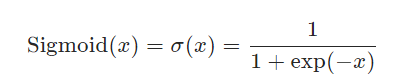



In [16]:

class RNNModel(nn.Module):
    def __init__(self,sequence_dim,sequence_n, device, hidden_size=128):
        super(RNNModel, self).__init__()
        #keep track of the device (to use gpu)
        self.device = device
        #Defining the input shape
        self.sequence_n = sequence_n
        self.hidden_size = hidden_size
        self.sequence_dim=sequence_dim
        #create the rnn which goes input+hidden-> new hidden
        self.rnn_cell = torch.nn.GRUCell(self.sequence_dim, hidden_size)
        #create the output layer for hidden -> classification
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, sequence_dim),
            #sigmoid is used to squish outputs between 0 and 1
            torch.nn.Sigmoid()                             
        )
        #cast networks to the device (so we can run the model on the gpu)
        self.to(self.device)
        

    def forward(self, x):
        samplesize=x.shape[0]
        #Initialize the hidden state
        hidden_state = torch.zeros(samplesize, self.hidden_size,device=self.device)
        for step in range(self.sequence_n):
            #calculate new hidden state
            hidden_state = self.rnn_cell(x[:,step], hidden_state)
        #Apply the output network to the hidden state and return the output
        return self.dense(hidden_state)

Adam[¶](#adam "Permalink to this headline")
===========================================

_class_ `torch.optim.``Adam`(_params_, _lr=0.001_, _betas=(0.9_, _0.999)_, _eps=1e-08_, _weight_decay=0_, _amsgrad=False_)[\[source\]](https://pytorch.org/docs/stable/_modules/torch/optim/adam.html#Adam)[¶](#torch.optim.Adam "Permalink to this definition")

Implements Adam algorithm.

It has been proposed in [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980). The implementation of the L2 penalty follows changes proposed in [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101).

Parameters

* **params** (_iterable_) – iterable of parameters to optimize or dicts defining parameter groups
    
* **lr** ([_float_](https://docs.python.org/3/library/functions.html#float "(in Python v3.9)")_,_ _optional_) – learning rate (default: 1e-3)
    
* **betas** (_Tuple__\[_[_float_](https://docs.python.org/3/library/functions.html#float "(in Python v3.9)")_,_ [_float_](https://docs.python.org/3/library/functions.html#float "(in Python v3.9)")_\]__,_ _optional_) – coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    
* **eps** ([_float_](https://docs.python.org/3/library/functions.html#float "(in Python v3.9)")_,_ _optional_) – term added to the denominator to improve numerical stability (default: 1e-8)
    
* **weight_decay** ([_float_](https://docs.python.org/3/library/functions.html#float "(in Python v3.9)")_,_ _optional_) – weight decay (L2 penalty) (default: 0)
    
* **amsgrad** (_boolean__,_ _optional_) – whether to use the AMSGrad variant of this algorithm from the paper [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ) (default: False)
    
    

ExponentialLR[¶](#exponentiallr "Permalink to this headline")
=============================================================

_class_ `torch.optim.lr_scheduler.``ExponentialLR`(_optimizer_, _gamma_, _last_epoch=-1_, _verbose=False_)[\[source\]](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR)[¶](#torch.optim.lr_scheduler.ExponentialLR "Permalink to this definition")

Decays the learning rate of each parameter group by gamma every epoch. When last_epoch=-1, sets initial lr as lr.

Parameters

* **optimizer** ([_Optimizer_](../optim.html#torch.optim.Optimizer "torch.optim.Optimizer")) – Wrapped optimizer.
    
* **gamma** ([_float_](https://docs.python.org/3/library/functions.html#float "(in Python v3.9)")) – Multiplicative factor of learning rate decay.
    
* **last_epoch** ([_int_](https://docs.python.org/3/library/functions.html#int "(in Python v3.9)")) – The index of last epoch. Default: -1.
    
* **verbose** ([_bool_](https://docs.python.org/3/library/functions.html#bool "(in Python v3.9)")) – If `True`, prints a message to stdout for each update. Default: `False`.
    

# Training the Network

I'm just doing simple training with a decaying learning rate and
stopping early to discourage overfitting

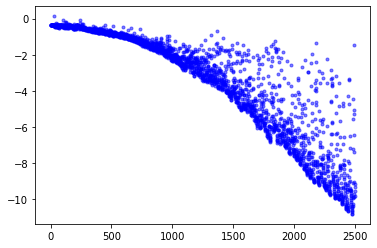

In [41]:
#set learning rate paramaters
lr = 2e-3
lr_gamma = 0.999
betas = (0.5, 0.5)
#Create the RNN model
rnn=RNNModel(1,60,device)
#set up the optimizer and learning rate scheduler
optimizer = optim.Adam(rnn.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)



loss_log=[]

def train(x, target, optimizer, scheduler):
    #get predictions
    y = rnn(x)
    #compare predictions with binary cross entropy
    loss = F.binary_cross_entropy(y,target)
    #reset optimizer gradients
    optimizer.zero_grad()
    #backprop
    loss.backward()
    #optimize network prameters with adam
    optimizer.step()
    #uptate learning rate
    scheduler.step()
    return y, loss

#training loop
#there is no validation so It just stops a bit early
for i in range(2500):
    out,loss=train(TrainData,TrainLabels,optimizer,scheduler)
    loss_log.append(np.log(loss.item()))
plt.plot(loss_log,'b.',alpha=0.5)
plt.show()

In [42]:
print(100-torch.sum((rnn(TestData)>0.5)^(TestLabels>0.5)).item()/len(TestLabels)*100,"% Test Accuracy")

85.3658536585366 % Test Accuracy


Recall: The cited accuracy of this was also about 85% so this is a satisfactory result

# This just helps me format Markdown

In [2]:
x="a\tb\tc\n1\t22\t3"
N=4
alt=""
off=0
for a in x:
    if a=='\n':
        alt+='<br />'
        off=0
    elif a=='\t': 
        alt+= '&ensp;'*(N-off)
        off=0
    else:
        alt+=a
        off=(off+1)%N
print(alt)
display.display(display.Markdown(alt))

a&ensp;&ensp;&ensp;b&ensp;&ensp;&ensp;c<br />1&ensp;&ensp;&ensp;22&ensp;&ensp;3


a&ensp;&ensp;&ensp;b&ensp;&ensp;&ensp;c<br />1&ensp;&ensp;&ensp;22&ensp;&ensp;3